#Logistic regression model

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer

# Load the training and test datasets
train_data = pd.read_csv('/content/train.csv', dtype={'yr': str})
test_data = pd.read_csv('/content/test.csv', dtype={'yr': str})


# Define features and target variable
numeric_features = ['GP', 'Min_per', 'Ortg', 'usg', 'eFG', 'TS_per', 'ORB_per', 'DRB_per',
                   'AST_per', 'TO_per', 'FTM', 'FTA', 'FT_per', 'twoPM', 'twoPA', 'twoP_per',
                   'TPM', 'TPA', 'TP_per', 'blk_per', 'stl_per', 'ftr', 'porpag', 'adjoe',
                   'Rec_Rank', 'ast_tov', 'rim_ratio', 'mid_ratio', 'dunks_ratio',
                   'pick', 'drtg', 'adrtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm',
                   'mp', 'ogbpm', 'dgbpm', 'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk', 'pts']

target = 'drafted'


<ipython-input-6-187a613a1c1c>:9: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('/content/train.csv', dtype={'yr': str})


DATA SPLITTING

In [14]:
# Split data into features and target

X = train_data[numeric_features]
y = train_data[target]

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a SimpleImputer to fill missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# Preprocess numeric features using standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

Initialize and train a logistic regression model

In [7]:
model = LogisticRegression(random_state=42, max_iter=1000)  # or a higher value
model.fit(X_train_scaled, y_train)

# Predict probabilities on the validation set
y_val_pred_prob = model.predict_proba(X_val_scaled)[:, 1]

# Calculate AUROC score
auroc_score = roc_auc_score(y_val, y_val_pred_prob)
print(f'AUROC Score: {auroc_score:.4f}')

# Preprocess
X_test = test_data[numeric_features]
X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)

# Predict probabilities on the test set
y_test_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# submission file
submission = pd.DataFrame({'player_id': test_data['player_id'], 'drafted': y_test_pred_prob})
submission.to_csv('submission.csv', index=False)


AUROC Score: 0.9891


Plotting AUROC SCORE

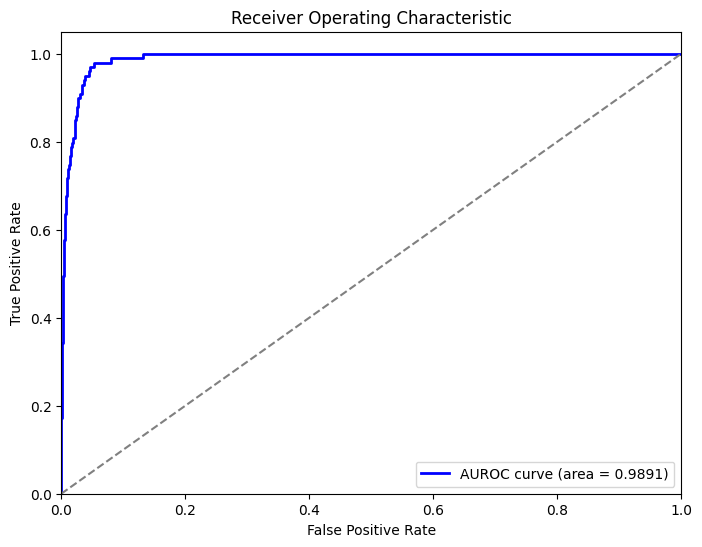

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_val, y_val_pred_prob)

# Plot AUROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUROC curve (area = %0.4f)' % auroc_score)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


#Train a Random Forest Classifier

Initializing and training a Random Forest Classifier model

In [9]:
from sklearn.ensemble import RandomForestClassifier


rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict probabilities on the validation set
y_val_rf_pred_prob = rf_model.predict_proba(X_val_scaled)[:, 1]

# Calculate AUROC score for Random Forest model
auroc_score_rf = roc_auc_score(y_val, y_val_rf_pred_prob)
print(f'AUROC Score (Random Forest): {auroc_score_rf:.4f}')


AUROC Score (Random Forest): 0.9963


In [10]:
print(f'AUROC Score (Logistic Regression): {auroc_score:.4f}')
print(f'AUROC Score (Random Forest): {auroc_score_rf:.4f}')


AUROC Score (Logistic Regression): 0.9891
AUROC Score (Random Forest): 0.9963


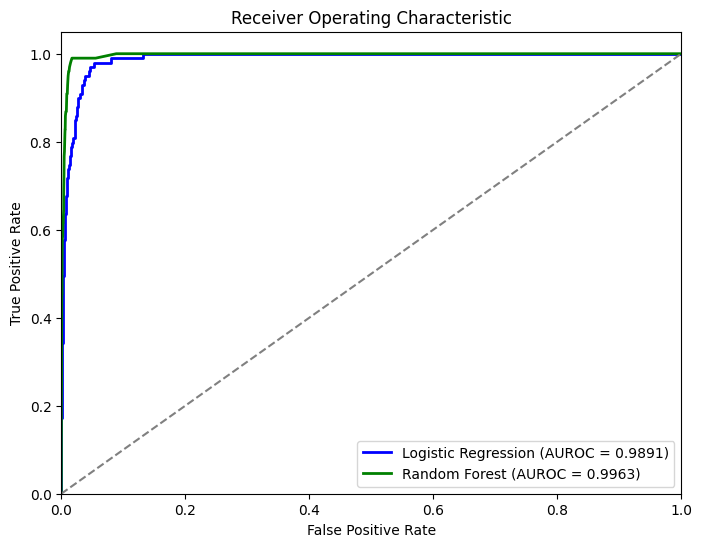

In [11]:
# Compute ROC curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_val_rf_pred_prob)

# Plot AUROC curve for Random Forest
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='Logistic Regression (AUROC = %0.4f)' % auroc_score)
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label='Random Forest (AUROC = %0.4f)' % auroc_score_rf)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [12]:
# Replace missing values in the test data
X_test_cleaned = X_test.fillna(0)

X_test_scaled = scaler.transform(X_test_cleaned)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


predictions from the Random Forest model for each player

In [13]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Train the Random Forest model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_scaled, y_train)

# Predict probabilities on the test set
y_test_pred_prob_rf = model_rf.predict_proba(X_test_scaled)[:, 1]

# Create a DataFrame to hold player_id and predicted probabilities
predictions_df = pd.DataFrame({'player_id': test_data['player_id'], 'drafted': y_test_pred_prob_rf})

# Save to a CSV file
predictions_df.to_csv('random_forest_predictions.csv', index=False)
